In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift

In [22]:
Data= "/content/drive/My Drive/checkins.dat"

In [23]:
df = pd.read_csv(Data, sep='|', header=0, skipinitialspace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
print(df.shape)
df.head()

(1021968, 6)


,id,user_id,venue_id,latitude,longitude,created_at
0,---------+---------+----------+---------------...,NaN,NaN,NaN,NaN,NaN
1,984301,2041916.0,5222.0,NaN,NaN,2012-04-21 17:39:01
2,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
3,984315,1764391.0,5222.0,NaN,NaN,2012-04-21 17:37:18
4,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43


Удалим строки, не содержащие координат — они неинформативны 

In [25]:
df.dropna(inplace=True)
df.columns = [name.strip() for name in df.columns]

In [26]:
df.head()

,id,user_id,venue_id,latitude,longitude,created_at
2,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
4,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
8,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
10,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
11,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


Убедимся, что все 396634 строки с координатами считаны успешно.

In [29]:
len(df)

396634

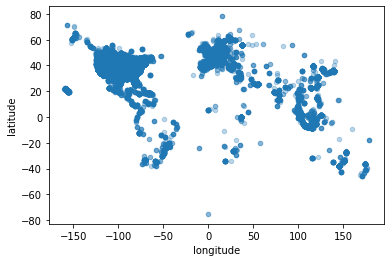

In [30]:
df.plot.scatter(x='longitude', y='latitude', alpha=0.3)

Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров

Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

In [31]:
df = df.iloc[0:100000]

In [32]:
df

,id,user_id,venue_id,latitude,longitude,created_at
2,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
4,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
8,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
10,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
11,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18
...,...,...,...,...,...,...
233789,123888,1019078.0,1105563.0,33.575000,-117.725556,2011-12-11 05:38:19
233790,124366,771129.0,329847.0,37.629349,-122.400087,2011-12-11 04:55:34
233794,125556,804990.0,254046.0,29.762884,-95.383061,2011-12-11 06:54:20
233798,127250,526214.0,34473.0,32.802955,-96.769923,2011-12-11 10:05:38


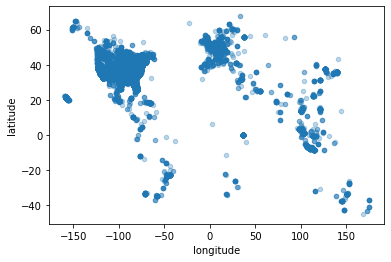

In [33]:
df.plot.scatter(x='longitude', y='latitude', alpha=0.3)

In [34]:
from sklearn.cluster import MeanShift

Используется алгоритм MeanShift

bandwidth=0.1, в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

In [35]:
cluster = MeanShift(bandwidth=0.1)

In [36]:
cluster.fit(df[['latitude', 'longitude']])

MeanShift(bandwidth=0.1)

In [39]:
cluster_centers_x = [el[1] for el in cluster.cluster_centers_]
cluster_centers_y = [el[0] for el in cluster.cluster_centers_]

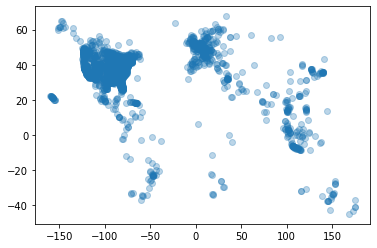

In [40]:
plt.scatter(x=cluster_centers_x, y=cluster_centers_y, alpha=0.3)

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

In [41]:
big_clasters = []
for label in set(cluster.labels_):
    if len(cluster.labels_[cluster.labels_ == label]) >= 15:
        big_clasters.append(label)

Получены следующие координаты кластеров

In [43]:
cluster_centers = pd.DataFrame({'longitude': cluster_centers_x,
                                'latitude': cluster_centers_y, 'label': range(len(cluster_centers_x))})
big_cluster_centers = cluster_centers[cluster_centers['label'].isin(big_clasters)]
big_cluster_centers

,longitude,latitude,label
0,-73.991835,40.717716,0
1,-112.002140,33.449438,1
2,-111.901888,33.446380,2
3,-87.629843,41.878244,3
4,-122.409330,37.688682,4
...,...,...,...
712,-122.940805,49.199791,712
727,-73.666619,41.220398,727
884,-88.445568,41.618532,884
1343,-77.182127,39.249469,1343


In [46]:
cluster_centers_x = big_cluster_centers['longitude']
cluster_centers_y = big_cluster_centers['latitude']

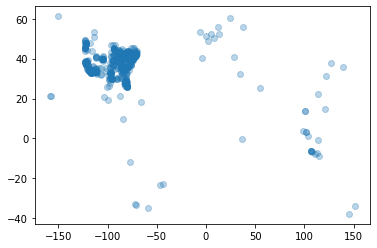

In [47]:
plt.scatter(cluster_centers_x, cluster_centers_y, alpha = 0.3)

Найдем на Google Maps по запросу Carnival Cruise Line адреса всех офисов:

In [93]:
offices = [[34.2720355,-118.4693734], [33.7507188,-118.1889072], [27.9450524,-82.4455656],
                  [39.2650447,-76.6007999], [32.717609,-117.1761962], [37.804883,-122.4016302],
                  [49.2514431,-123.1277804], [32.7859233,-79.9333731], [30.6860768,-88.0394999],
                  [26.1216934,-80.1388889], [33.3882696,-111.6913768], [26.0853385,-80.1180988],
                  [30.0068944,-90.1633797], [29.3075638,-94.7986193], [28.4157244,-80.6310168],
                  [52.3787031,4.8849274], [47.3831508,8.4987319], [41.3905199,2.1570719],
                  [50.4356475,30.5142909], [53.4699633,-2.2947828]]

In [105]:
office_centers_x = [34.2720355, 33.7507188, 27.9450524, 39.2650447, 32.717609, 37.804883, 49.2514431, 32.7859233, 30.6860768, 26.1216934, 33.3882696, 26.0853385, 30.0068944, 29.3075638, 28.4157244,  52.3787031, 47.3831508, 41.3905199, 50.4356475, 53.4699633]
office_centers_y = [-118.4693734,-118.1889072,-82.4455656,-76.6007999,-117.1761962,-122.4016302,-123.1277804,-79.9333731,-88.0394999,-80.1388889,-111.6913768,-80.1180988,-90.1633797,-94.7986193,-80.6310168,4.8849274,8.4987319,2.1570719,30.5142909,-2.2947828]              

In [133]:
office_centers = pd.DataFrame({'latitude': office_centers_x,
                                'longitude': office_centers_y, 'label': range(len(offices))})
office_centers

,latitude,longitude,label
0,34.272036,-118.469373,0
1,33.750719,-118.188907,1
2,27.945052,-82.445566,2
3,39.265045,-76.600800,3
4,32.717609,-117.176196,4
5,37.804883,-122.401630,5
6,49.251443,-123.127780,6
7,32.785923,-79.933373,7
8,30.686077,-88.039500,8
9,26.121693,-80.138889,9


In [134]:
office_centers = office_centers.astype('float64')
offices_for_dist = office_centers.loc[:, ['latitude', 'longitude']]
offices_for_dist
datatypes = offices_for_dist.dtypes 
print(datatypes)
offices_for_dist.loc[0]


latitude     float64
longitude    float64
dtype: object


latitude      34.272036
longitude   -118.469373
Name: 0, dtype: float64

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

In [136]:
distances = []
min_distance = 4000
best_center = [3000, 3000]
for address in offices:
    best_distance = 4000
    distances.append([3000, 3000])
    for i in range(len(big_cluster_centers)):
        distance = (address[0] - big_cluster_centers.iloc[i, 1]) ** 2 + (address[1] - big_cluster_centers.iloc[i, 0]) ** 2
        if distance < best_distance:
            best_distance = distance
            distances[-1] = [big_cluster_centers.iloc[i, 1], big_cluster_centers.iloc[i, 0]]
    if best_distance < min_distance:
        best_center = distances[-1]
        min_distance = best_distance
distances

[[34.198182070921945, -118.54927680780153],
 [33.8098779552631, -118.14892380690816],
 [27.94944607964624, -82.4650735999998],
 [39.28625030782621, -76.61466929101515],
 [32.71134443394277, -117.15363874791043],
 [37.68868157406161, -122.40933037359147],
 [49.24017197830703, -123.11186022275179],
 [32.78430573736261, -79.92050398571432],
 [30.6943566, -88.0430541],
 [26.120862658633104, -80.1589066802157],
 [33.357344562325096, -111.82265410760392],
 [26.120862658633104, -80.1589066802157],
 [29.986731291666665, -90.20393365555553],
 [29.762697754725156, -95.3823137047244],
 [28.329701672413794, -80.6728876965517],
 [52.37296399032261, 4.892317222580647],
 [50.11151180000001, 8.6805059],
 [40.417455494444454, -3.700910200000001],
 [55.748349518181776, 37.62385041818183],
 [51.50299126088708, -0.12553728870967767]]

In [137]:
best_center

[30.6943566, -88.0430541]

In [138]:
min_distance

8.118742568008192e-05